In [83]:
# Import Required Libraries
library(dplyr)
library(tsibble)
library(fable)
library(ggplot2)
library(tidyr)
library(purrr)
library(feasts)


In [84]:
# Source Helper Functions
source("baseline_helpers.R")
source("../Data_Inspection/data_cleaning_helpers.R")


In [85]:
# Clean validation data
validation <- clean_validation_data(read.csv("../sales_test_validation_afcs2025.csv")) |>
  as_tsibble(index = day, key = product)
validation


product,day,sales
<chr>,<date>,<int>
FOODS_3_001,2016-04-25,1
FOODS_3_001,2016-04-26,0
FOODS_3_001,2016-04-27,0
FOODS_3_001,2016-04-28,1
FOODS_3_001,2016-04-29,0
FOODS_3_001,2016-04-30,1
FOODS_3_001,2016-05-01,0
FOODS_3_001,2016-05-02,0
FOODS_3_001,2016-05-03,0


## Load and Clean Train Data

In [86]:
# Load train data
train <- read.csv("../sales_train_validation_afcs2025.csv")

# Clean train data
cleaned_train <- clean_train_data(train)

# Display cleaned data
head(cleaned_train)


day,FOODS_3_001,FOODS_3_002,FOODS_3_003,FOODS_3_004,FOODS_3_005,FOODS_3_006,FOODS_3_007,FOODS_3_008,FOODS_3_009,⋯,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
<date>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2011-01-29,0,0,0,0,0,0,27,0,0,⋯,0,9,3,0,7,0,0,0,0,0
2011-01-30,2,0,0,0,1,0,27,0,0,⋯,0,0,2,0,5,0,1,0,0,0
2011-01-31,1,0,0,0,1,0,8,0,0,⋯,0,3,1,0,5,0,0,0,0,0
2011-02-01,3,0,0,0,0,0,0,0,0,⋯,0,0,3,0,3,0,1,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,1,0,0
2011-02-03,0,0,0,0,1,0,11,0,0,⋯,0,6,0,0,3,0,2,1,0,0


## Baseline Prediction

In [87]:
# Fit a seasonal naive model for each time series
baseline_model <- cleaned_train %>%
  pivot_longer(cols = -day, names_to = "product", values_to = "sales") %>%
  group_by(product) %>%
  model(SNAIVE(sales))

# Generate forecasts for the next 28 days
snaive_forecasts <- baseline_model %>%
  forecast(h = "28 days") %>%
  as_tibble() %>%
  mutate(sales = map_dbl(.mean, ~.))

# Format predictions for submission
snaive_formatted_predictions <- snaive_forecasts %>%
  select(day, product, sales) %>%
  pivot_wider(names_from = product, values_from = sales) %>%
  format_predictions(start_date = "2016-04-25")

# Display formatted predictions
head(snaive_formatted_predictions)


day,id,sales
<date>,<chr>,<dbl>
2016-04-25,FOODS_3_001,0
2016-04-25,FOODS_3_002,0
2016-04-25,FOODS_3_003,0
2016-04-25,FOODS_3_004,0
2016-04-25,FOODS_3_005,1
2016-04-25,FOODS_3_006,1


## Evaluate Predictions

In [88]:
# Align predictions and validation data using helper function
snaive_aligned_data <- align_predictions(snaive_formatted_predictions, validation)

# Evaluate predictions using helper function
metrics <- calculate_metrics(snaive_aligned_data)

# Display evaluation metrics
print(metrics)


# A tibble: 1 × 2
   RMSE   MAE
  <dbl> <dbl>
1  3.68  1.70


In [89]:
data <- cleaned_train %>%
  pivot_longer(cols = -day, names_to = "product", values_to = "sales") %>%
  group_by(product)
dates <- read.csv("../calendar_afcs2025.csv") |> mutate(date = as.Date(date, format = "%m/%d/%Y"))
dates <- dates |> rename(day = date)

# extending it by adding calander data
train <- inner_join(
  data,
  dates,
  by = c("day")
)
train <- train |> as_tsibble(index = day, key = product)


In [90]:
prices <- read.csv("../sell_prices_afcs2025.csv") |>
    rename(product = item_id) |>
    select(-store_id)


# extending it by price
train <- inner_join(
    train,
    prices,
    by = c("product", "wm_yr_wk")
)
train

small_train <- train |> filter(
    product == "FOODS_3_001" |
        product == "FOODS_3_002" |
        product == "FOODS_3_003"
)
# product == "FOODS_3_004" |
# product == "FOODS_3_005" |
# product == "FOODS_3_006" |
# product == "FOODS_3_007" |
# product == "FOODS_3_008" |
# product == "FOODS_3_009" |
# product == "FOODS_3_010"


small_train <- small_train |> mutate(log_sales = log(sales + 1))


day,product,sales,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,sell_price
<date>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
2011-01-29,FOODS_3_001,0,11101,Saturday,1,1,2011,NA,NA,NA,NA,0,2.28
2011-01-30,FOODS_3_001,2,11101,Sunday,2,1,2011,NA,NA,NA,NA,0,2.28
2011-01-31,FOODS_3_001,1,11101,Monday,3,1,2011,NA,NA,NA,NA,0,2.28
2011-02-01,FOODS_3_001,3,11101,Tuesday,4,2,2011,NA,NA,NA,NA,1,2.28
2011-02-02,FOODS_3_001,0,11101,Wednesday,5,2,2011,NA,NA,NA,NA,0,2.28
2011-02-03,FOODS_3_001,0,11101,Thursday,6,2,2011,NA,NA,NA,NA,1,2.28
2011-02-04,FOODS_3_001,1,11101,Friday,7,2,2011,NA,NA,NA,NA,0,2.28
2011-02-05,FOODS_3_001,0,11102,Saturday,1,2,2011,NA,NA,NA,NA,1,2.28
2011-02-06,FOODS_3_001,2,11102,Sunday,2,2,2011,SuperBowl,Sporting,NA,NA,1,2.28


`mutate_if()` ignored the following grouping variables:
• Column `product`


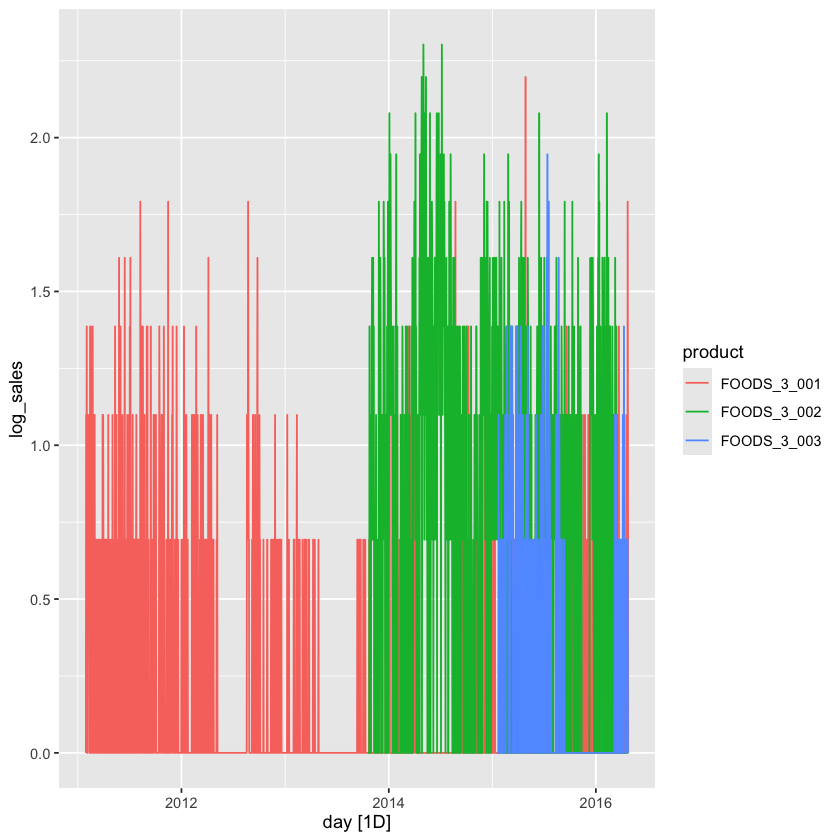

In [91]:
ok <- small_train %>%
    group_by(product) %>%
    summarise(ndiffs = unitroot_ndiffs(sales))

small_train |> autoplot(.vars = log_sales)


In [92]:
fit <- small_train |>
  model(ARIMA(log_sales ~ sell_price + pdq(d = 1)))
fit
report(fit |> filter(product == "FOODS_3_003"))


product,ARIMA(log_sales ~ sell_price + pdq(d = 1))
<chr>,<model>
FOODS_3_001,"<LM w/ ARIMA(2,1,2)(2,0,0)[7] errors>"
FOODS_3_002,"<LM w/ ARIMA(3,1,2)(1,0,0)[7] errors>"
FOODS_3_003,"<LM w/ ARIMA(0,1,1)(1,0,1)[7] errors>"


Series: log_sales 
Model: LM w/ ARIMA(0,1,1)(1,0,1)[7] errors 

Coefficients:
          ma1     sar1    sma1  sell_price
      -0.8327  -0.2840  0.3633      0.2742
s.e.   0.0334   0.3183  0.3079      0.0849

sigma^2 estimated as 0.1416:  log likelihood=-203.06
AIC=416.12   AICc=416.25   BIC=436.81


In [93]:
sell_price_future <- price_fit |> forecast(h = "28 days")


In [94]:
price_fit <- small_train |>
  model(NAIVE(sell_price))
price_fit
report(price_fit |> filter(product == "FOODS_3_003"))


product,NAIVE(sell_price)
<chr>,<model>
FOODS_3_001,<NAIVE>
FOODS_3_002,<NAIVE>
FOODS_3_003,<NAIVE>


Series: sell_price 
Model: NAIVE 

sigma^2: 0.0176 


In [ ]:
sell_price_future <- price_fit |>
  forecast(h = "28 days") |>
  as_tsibble() |>
  select(product, day, .mean) |>
  rename(sell_price = .mean)


joined <- sell_price_future

predictions <- forecast(fit, new_data = joined) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  select(day, product, sales)
predictions


day,product,sales
<date>,<chr>,<dbl>
2016-04-25,FOODS_3_001,0.45074908
2016-04-26,FOODS_3_001,0.41489809
2016-04-27,FOODS_3_001,0.32356075
2016-04-28,FOODS_3_001,0.31610139
2016-04-29,FOODS_3_001,0.44303403
2016-04-30,FOODS_3_001,0.38888030
2016-05-01,FOODS_3_001,0.30928608
2016-05-02,FOODS_3_001,0.33480163
2016-05-03,FOODS_3_001,0.41097656


In [ ]:
formatted_predictions <- predictions %>%
  select(day, product, sales) %>%
  pivot_wider(names_from = product, values_from = sales) %>%
  format_predictions(start_date = "2016-04-25")

# Align predictions and validation data using helper function
aligned_data <- align_predictions(formatted_predictions, validation)

# Evaluate predictions using helper function
metrics <- calculate_metrics(aligned_data)

# Display evaluation metrics
print(metrics)


# A tibble: 1 × 2
   RMSE   MAE
  <dbl> <dbl>
1  1.16 0.770


In [97]:
fit <- train |>
  model(
    SNAIVE(sales)
  )

forecasts <- fit |>
  forecast(h = 28)

accuracy <- forecasts |> accuracy(validation)
accuracy


.model,product,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SNAIVE(sales),FOODS_3_001,Test,-0.85714286,2.1876275,1.4285714,-Inf,Inf,NaN,NaN,-0.24829075
SNAIVE(sales),FOODS_3_002,Test,1.03571429,1.6146649,1.0357143,100.000000,100.00000,NaN,NaN,0.13795867
SNAIVE(sales),FOODS_3_003,Test,0.42857143,1.1019463,0.8571429,-Inf,Inf,NaN,NaN,-0.16973126
SNAIVE(sales),FOODS_3_004,Test,0.17857143,0.4225771,0.1785714,100.000000,100.00000,NaN,NaN,0.01832298
SNAIVE(sales),FOODS_3_005,Test,0.78571429,2.1044171,1.6428571,-Inf,Inf,NaN,NaN,-0.26749857
SNAIVE(sales),FOODS_3_006,Test,0.85714286,1.8708287,1.2142857,-Inf,Inf,NaN,NaN,-0.12018977
SNAIVE(sales),FOODS_3_007,Test,5.75000000,8.1437969,5.7500000,100.000000,100.00000,NaN,NaN,-0.04489933
SNAIVE(sales),FOODS_3_008,Test,6.25000000,10.7154761,6.2500000,100.000000,100.00000,NaN,NaN,0.79655274
SNAIVE(sales),FOODS_3_009,Test,0.42857143,1.3887301,0.9285714,-Inf,Inf,NaN,NaN,0.36758563


In [ ]:
fit <- train |>
  model(
    ARIMA(sales)
  )

forecasts <- fit |>
  forecast(h = 28)

accuracy <- forecasts |> accuracy(validation)
accuracy


Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”


In [ ]:
# interesting variables

# price => we can probaby try out
# naive (easy, assumption that prices stay the same)
# ets (makes sense, prices change and most recent observations should weigh more)
# Arima (just to see what pops out)
# snaive?

# events
# probaby don't need to predict it,
# these we can probably look up from the years before

# here we might want to either focus on the category itself or on the event

# snap_TX might be interesting? can probably look it up

# weekday   wday month could be interesting, these we also don't need to predict,
# maybe include feature "week", so what week it is
